In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from natsort import natsorted

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Configuration
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 50
VAL_SPLIT = 0.2
DATA_PATH = "output_images/"
RF_PATH = os.path.join(DATA_PATH, "rf")
ROI_PATH = os.path.join(DATA_PATH, "roi")

# Data Loading with PyTorch Dataset
class UltrasoundDataset(Dataset):
    def __init__(self, rf_path, roi_path, transform=None):
        self.rf_images = []
        self.roi_masks = []
        self.transform = transform
        valid_extensions = ('.png', '.jpg', '.jpeg')
        rf_files = natsorted([f for f in os.listdir(rf_path) if f.lower().endswith(valid_extensions)])
        roi_files = natsorted([f for f in os.listdir(roi_path) if f.lower().endswith(valid_extensions)])
        
        if len(rf_files) != len(roi_files):
            raise ValueError(f"Mismatched files: {len(rf_files)} RF vs {len(roi_files)} ROI")
        
        for rf_file, roi_file in zip(rf_files, roi_files):
            rf_img = cv2.imread(os.path.join(rf_path, rf_file), cv2.IMREAD_GRAYSCALE)
            roi_img = cv2.imread(os.path.join(roi_path, roi_file), cv2.IMREAD_GRAYSCALE)
            
            if rf_img is None or roi_img is None:
                continue
            
            rf_img = cv2.resize(rf_img, IMG_SIZE)
            roi_img = cv2.resize(roi_img, IMG_SIZE)
            roi_img = (roi_img > 127).astype(np.float32)
            
            self.rf_images.append(rf_img)
            self.roi_masks.append(roi_img)

    def __len__(self):
        return len(self.rf_images)

    def __getitem__(self, idx):
        img = self.rf_images[idx].astype(np.float32) / 255.0
        mask = self.roi_masks[idx].astype(np.float32)
        img = torch.tensor(img).unsqueeze(0)  # Add channel dim
        mask = torch.tensor(mask).unsqueeze(0)
        return img, mask

# Define U-Net Model in PyTorch
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU()
            )
        
        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        
        self.pool = nn.MaxPool2d(2)
        
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = conv_block(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = conv_block(128, 64)
        
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1)
        
    def forward(self, x):
        c1 = self.enc1(x)
        p1 = self.pool(c1)
        c2 = self.enc2(p1)
        p2 = self.pool(c2)
        c3 = self.enc3(p2)
        
        u3 = self.up3(c3)
        u3 = torch.cat([u3, c2], dim=1)
        c4 = self.dec3(u3)
        
        u2 = self.up2(c4)
        u2 = torch.cat([u2, c1], dim=1)
        c5 = self.dec2(u2)
        
        return torch.sigmoid(self.final_conv(c5))

# Training and Evaluation

def train_model():
    dataset = UltrasoundDataset(RF_PATH, ROI_PATH)
    train_size = int((1 - VAL_SPLIT) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    
    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCELoss()
    
    best_loss = float('inf')
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            predicted = (outputs > 0.5).float()
            correct += (predicted == masks).sum().item()
            total += masks.numel()
        
        train_accuracy = correct / total
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss/len(val_loader):.4f}")
        
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("Model saved!")
    
if __name__ == "__main__":
    train_model()


Epoch 1/50, Train Loss: 0.6416, Train Accuracy: 0.9442, Val Loss: 0.5404
Model saved!
Epoch 2/50, Train Loss: 0.2980, Train Accuracy: 0.9442, Val Loss: 0.2119
Model saved!
Epoch 3/50, Train Loss: 0.2094, Train Accuracy: 0.9442, Val Loss: 0.1967
Model saved!
Epoch 4/50, Train Loss: 0.2009, Train Accuracy: 0.9442, Val Loss: 0.1946
Model saved!
Epoch 5/50, Train Loss: 0.1949, Train Accuracy: 0.9442, Val Loss: 0.1875
Model saved!
Epoch 6/50, Train Loss: 0.1913, Train Accuracy: 0.9442, Val Loss: 0.1843
Model saved!
Epoch 7/50, Train Loss: 0.1900, Train Accuracy: 0.9442, Val Loss: 0.1842
Model saved!
Epoch 8/50, Train Loss: 0.1897, Train Accuracy: 0.9442, Val Loss: 0.1824
Model saved!
Epoch 9/50, Train Loss: 0.1888, Train Accuracy: 0.9442, Val Loss: 0.1856
Epoch 10/50, Train Loss: 0.1882, Train Accuracy: 0.9442, Val Loss: 0.1812
Model saved!
Epoch 11/50, Train Loss: 0.1862, Train Accuracy: 0.9442, Val Loss: 0.1801
Model saved!
Epoch 12/50, Train Loss: 0.1852, Train Accuracy: 0.9442, Val Loss

Total samples: 200


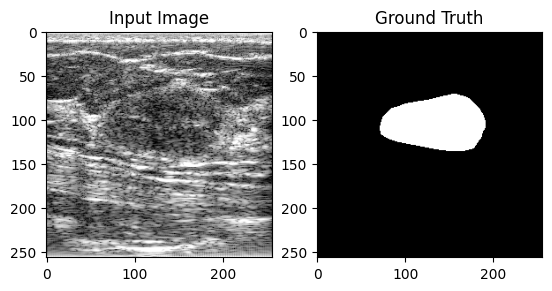


Epoch 1/100
Train Loss: 0.6536 | Acc: 0.6613 | Dice: 0.1530 | IoU: 0.0828
Val Loss: 0.6112 | Acc: 0.9371 | Dice: 0.0000 | IoU: 0.0000

Epoch 2/100
Train Loss: 0.5010 | Acc: 0.9282 | Dice: 0.1005 | IoU: 0.0529
Val Loss: 0.4655 | Acc: 0.9372 | Dice: 0.0000 | IoU: 0.0000

Epoch 3/100
Train Loss: 0.4388 | Acc: 0.9413 | Dice: 0.1265 | IoU: 0.0675
Val Loss: 0.4254 | Acc: 0.9378 | Dice: 0.1442 | IoU: 0.0777
Saved new best model with Dice: 0.1442

Epoch 4/100
Train Loss: 0.4104 | Acc: 0.9428 | Dice: 0.3374 | IoU: 0.2029
Val Loss: 0.4062 | Acc: 0.9370 | Dice: 0.3100 | IoU: 0.1834
Saved new best model with Dice: 0.3100

Epoch 5/100
Train Loss: 0.3901 | Acc: 0.9302 | Dice: 0.4282 | IoU: 0.2724
Val Loss: 0.4434 | Acc: 0.8298 | Dice: 0.3657 | IoU: 0.2237
Saved new best model with Dice: 0.3657

Epoch 6/100
Train Loss: 0.3706 | Acc: 0.9344 | Dice: 0.4344 | IoU: 0.2775
Val Loss: 0.4025 | Acc: 0.8769 | Dice: 0.4250 | IoU: 0.2699
Saved new best model with Dice: 0.4250

Epoch 7/100
Train Loss: 0.3506 | 

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from natsort import natsorted
import matplotlib.pyplot as plt  # For debug

# Configuration
IMG_SIZE = (256, 256)
BATCH_SIZE = 8
EPOCHS = 100  # Increased epochs
VAL_SPLIT = 0.2
DATA_PATH = "output_images/"
LABELS = ["0", "1"]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Enhanced Dataset Class with Augmentation
class UltrasoundDataset(Dataset):
    def __init__(self, data_path):
        self.rf_images = []
        self.roi_masks = []
        valid_extensions = ('.png', '.jpg', '.jpeg')

        for label in LABELS:
            rf_path = os.path.join(data_path, label, "rf")
            roi_path = os.path.join(data_path, label, "roi")
            
            rf_files = natsorted([f for f in os.listdir(rf_path) if f.lower().endswith(valid_extensions)])
            roi_files = natsorted([f for f in os.listdir(roi_path) if f.lower().endswith(valid_extensions)])

            for rf_file, roi_file in zip(rf_files, roi_files):
                # Load images
                rf_img = cv2.imread(os.path.join(rf_path, rf_file), cv2.IMREAD_GRAYSCALE)
                roi_img = cv2.imread(os.path.join(roi_path, roi_file), cv2.IMREAD_GRAYSCALE)
                
                if rf_img is None or roi_img is None:
                    continue
                
                # Resize and normalize
                rf_img = cv2.resize(rf_img, IMG_SIZE)
                roi_img = cv2.resize(roi_img, IMG_SIZE)
                roi_img = (roi_img > 127).astype(np.float32)

                # Data augmentation
                if np.random.rand() > 0.5:
                    rf_img = cv2.flip(rf_img, 1)
                    roi_img = cv2.flip(roi_img, 1)
                
                if np.random.rand() > 0.5:
                    angle = np.random.randint(-15, 15)
                    M = cv2.getRotationMatrix2D((IMG_SIZE[0]//2, IMG_SIZE[1]//2), angle, 1)
                    rf_img = cv2.warpAffine(rf_img, M, IMG_SIZE)
                    roi_img = cv2.warpAffine(roi_img, M, IMG_SIZE)

                self.rf_images.append(rf_img)
                self.roi_masks.append(roi_img)

    def __len__(self):
        return len(self.rf_images)

    def __getitem__(self, idx):
        img = torch.tensor(self.rf_images[idx], dtype=torch.float32).unsqueeze(0) / 255.0
        mask = torch.tensor(self.roi_masks[idx], dtype=torch.float32).unsqueeze(0)
        return img, mask

# Enhanced U-Net with Multi-Scale Features
class ImprovedUNet(nn.Module):
    def __init__(self):
        super(ImprovedUNet, self).__init__()
        
        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        
        # Encoder
        self.enc1 = conv_block(1, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)  # Added deeper layer
        self.pool = nn.MaxPool2d(2)
        
        # Decoder with multi-scale features
        self.up4 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec4 = conv_block(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec3 = conv_block(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = conv_block(128, 64)
        
        # Final output
        self.final = nn.Sequential(
            nn.Conv2d(64, 1, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        # Decoder
        d4 = self.up4(e4)
        d4 = torch.cat([d4, e3], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.up3(d4)
        d3 = torch.cat([d3, e2], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)
        
        return self.final(d2)
def calculate_metrics(TP, TN, FP, FN):
    eps = 1e-10
    return {
        'Accuracy': (TP + TN) / (TP + TN + FP + FN + eps),
        'Recall': TP / (TP + FN + eps),
        'Specificity': TN / (TN + FP + eps),
        'Precision': TP / (TP + FP + eps),
        'Dice': (2 * TP) / (2 * TP + FP + FN + eps),
        'IoU': TP / (TP + FP + FN + eps)
    }
# Training Function with Debug
def train_model():
    dataset = UltrasoundDataset(DATA_PATH)
    print(f"Total samples: {len(dataset)}")  # Debug dataset size
    
    # Visualize sample data
    sample_img, sample_mask = dataset[0]
    plt.subplot(121)
    plt.imshow(sample_img.squeeze(), cmap='gray')
    plt.title('Input Image')
    plt.subplot(122)
    plt.imshow(sample_mask.squeeze(), cmap='gray')
    plt.title('Ground Truth')
    plt.show()
    
    # Split dataset
    train_size = int((1 - VAL_SPLIT) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    
    model = ImprovedUNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    criterion = nn.BCELoss()
    
    best_dice = 0
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        train_TP, train_TN, train_FP, train_FN = 0, 0, 0, 0
        
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Calculate metrics
            with torch.no_grad():
                preds = (outputs > 0.5).float()
                TP = (preds * masks).sum().item()
                TN = ((1 - preds) * (1 - masks)).sum().item()
                FP = (preds * (1 - masks)).sum().item()
                FN = ((1 - preds) * masks).sum().item()
                
                train_TP += TP
                train_TN += TN
                train_FP += FP
                train_FN += FN
        
        # Validation
        model.eval()
        val_loss = 0
        val_TP, val_TN, val_FP, val_FN = 0, 0, 0, 0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                
                val_loss += criterion(outputs, masks).item()
                
                preds = (outputs > 0.5).float()
                TP = (preds * masks).sum().item()
                TN = ((1 - preds) * (1 - masks)).sum().item()
                FP = (preds * (1 - masks)).sum().item()
                FN = ((1 - preds) * masks).sum().item()
                
                val_TP += TP
                val_TN += TN
                val_FP += FP
                val_FN += FN
        
        # Calculate metrics
        train_metrics = calculate_metrics(train_TP, train_TN, train_FP, train_FN)
        val_metrics = calculate_metrics(val_TP, val_TN, val_FP, val_FN)
        
        # Update learning rate
        scheduler.step(val_loss)
        
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print(f"Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Acc: {train_metrics['Accuracy']:.4f} | "
              f"Dice: {train_metrics['Dice']:.4f} | "
              f"IoU: {train_metrics['IoU']:.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f} | "
              f"Acc: {val_metrics['Accuracy']:.4f} | "
              f"Dice: {val_metrics['Dice']:.4f} | "
              f"IoU: {val_metrics['IoU']:.4f}")
        
        # Save best model
        if val_metrics['Dice'] > best_dice:
            best_dice = val_metrics['Dice']
            torch.save(model.state_dict(), "best_model_seg.pth")
            print(f"Saved new best model with Dice: {best_dice:.4f}")

if __name__ == "__main__":
    train_model()

In [2]:
!pip install natsort